In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\david\AppData\Local\Temp\ipykernel_39048\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
#measurement
Measurement = Base.classes.measurement
#station
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
#look measurement col
columns = Measurement.__table__.columns

# Print the column names
for column in columns:
    print(column.name)

id
station
date
prcp
tobs


In [10]:
#look Station col
columns = Station.__table__.columns

# Print the column names
for column in columns:
    print(column.name)

id
station
name
latitude
longitude
elevation


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
lastdate = session.query(func.max(Measurement.date)).scalar()
lastdate

'2017-08-23'

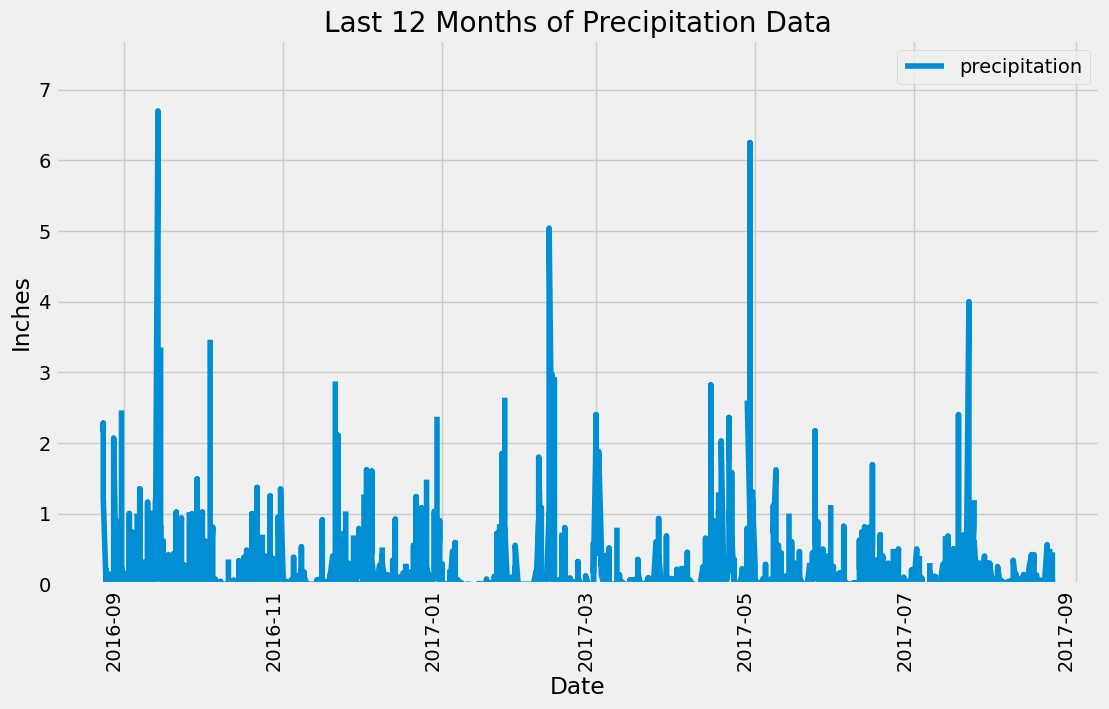

In [12]:
# Design a query to retrieve the last 12 months of precipitation data
# Starting from the most recent data point in the database

# Calculate the date one year from the last date in the data set
years = dt.datetime.strptime(lastdate, '%Y-%m-%d')

# Calculate the date one year ago from the last date in the data set
one_year_ago = years - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
pre_score = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
measurementdf = pd.DataFrame(pre_score).rename(columns = {'prcp': 'precipitation'})
#format dates 
measurementdf['date'] = pd.to_datetime(measurementdf['date'], format = '%Y-%m-%d')
#set index to date
measurementdf = measurementdf.set_index('date')
# Sort the dataframe by date
measurementdf = measurementdf.sort_values(by = ['date'])

# Use Pandas Plotting with Matplotlib to plot the data

measurementdf.plot(figsize = (12,8), rot=90)
plt.ylim(0,7.7)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.title('Last 12 Months of Precipitation Data')
plt.legend(loc = 'best')

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
stats = measurementdf.describe()
stats

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station).label('station_count'))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#getting the id with the most acitvity 
most_active_station = session.query(Measurement.station)\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .first()[0]

# Calculate the lowest, highest, and average temperature for the most active station witht the most activity 
temperature_stats = session.query(func.min(Measurement.tobs).label('lowest_temp'),
                                 func.max(Measurement.tobs).label('highest_temp'),
                                 func.avg(Measurement.tobs).label('average_temp'))\
    .filter(Measurement.station == most_active_station)\
    .first()
print(f"Lowest Temperature: {temperature_stats.lowest_temp}")
print(f"Highest Temperature: {temperature_stats.highest_temp}")
print(f"Average Temperature: {temperature_stats.average_temp}")


Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


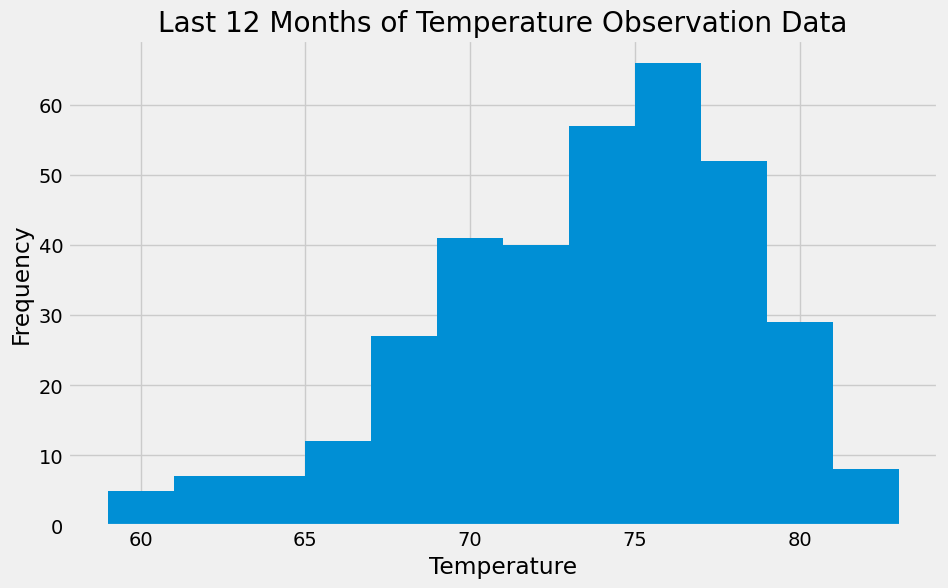

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last12 = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date >= one_year_ago).all()

# Convert to a DataFrame to plot data
last12df = pd.DataFrame(last12)

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
last12df['tobs'].plot(kind='hist', bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Last 12 Months of Temperature Observation Data')
plt.show()

# Close Session

In [18]:
# Close Session
session.close()